Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Импорт файла с данными для сравнения:

In [2]:
exp = pd.read_csv('EngineSem.ind', encoding='latin-1', header=None, skiprows = 19, delimiter='\s+')
exp.columns = ['Fi', 'Pc', 'Tc', 'Vc', 'Alf_w', 'P_1ring', 'G_bb', 'P_pist', 'x']
exp = exp[['Fi', 'Pc', 'Tc', 'x']]
exp['Pc'] = exp['Pc']*10**5
exp.head(5)

,Fi,Pc,Tc,x
0,180.0,193000.0,346.4,2.000000e+25
1,181.0,193000.0,346.5,2.000000e+25
2,182.0,193000.0,346.6,2.000000e+25
3,183.0,193000.0,346.7,2.000000e+25
4,184.0,193000.0,346.8,2.000000e+25


# Исходные данные по двигателю

### Геометрические параметры двигателя

In [3]:
D=0.102          # диаметр цилиндра, м
S=0.122          # ход поршня, м
n_mex=0.82956    # механический КПД
n=2400           # частота вращения, об/мин
icyl=6           # кол-во цилиндров
eps=18           # степень сжатия
lamb=0.264       # R/L
qc  = 7.05e-05  # Цикловая подача
Hu = 42.5*10**6

### Прочие константы

In [4]:
Rm=8.314          # Универсальная газовая постоянная
dFi=np.pi/180     # Приращение угла поворота КВ
N=900             # Статическое количество элементов в массивах

# Функции

### Объем КС как функция угла поворота коленчатого вала:
$$ V(\phi) = V_c + V_h -\frac{\pi D^2} 4 \frac{S} 2 ((1 - cos (\phi))-\frac{\lambda} 4 (1 -cos(2\phi)))$$

In [5]:
def Vol(deg):
    Ap = np.pi * D ** 2 / 4
    Vh = Ap * S
    Vc = Vh / (eps - 1)
    V = Vc + Vh - Ap * S / 2 * (1 - np.cos(np.deg2rad(deg)) - lamb / 4 * (1 - np.cos(2*np.deg2rad(deg))))
    return (V)

### Термодинамическая работа
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$

In [6]:
def dL(P, Fi):
    dl = -P * (Vol(Fi+1) - Vol(Fi))/dFi
    return dl

### Теплообмен с окружающими деталями КС:
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Площадь крышки цилиндра:
$$ F_k = \frac{\pi D^2} 4 $$
Площадь поршня:
$$ F_p = 1.4 F_k $$
Площадь гильзы:
$$ F_{cyl}(\phi) = {\pi D}(\delta + S_p(\phi)) $$
Коэффициент теплоотдачи по формуле Г. Эйхельберга:
$$ \alpha_w(\phi) = 77.9 \cdot 10^{-4} C_m^{\frac 1 3} \sqrt{PT} $$

In [7]:
def dQw(P, T, Fi):
    delta = 0.005
    T_h = 473
    T_cyl = 420
    T_p = 521
    Cm = S * n / 30
    Fpist = np.pi*D**2/4
    Vh = Fpist * S
    Vc = Vh / (eps - 1)
    Fcyl = ((Vol(Fi) - Vc) / Fpist + delta) * np.pi * D
    alfa_w =77.9 * 10 ** (-4) * Cm ** (1 / 3) * np.sqrt(P * T)
    dQh = alfa_w * (T - T_h) * 1.4 * Fpist
    dQcyl = alfa_w * (T - T_cyl) * Fcyl
    dQp = alfa_w * (T - T_p) * Fpist
    dqw = -(dQp + dQcyl + dQh) / (np.pi * n / 30)
    return dqw

# Основная программа

### Получение данных о характеристике тепловыделения

Пусть пока теплоемкость будет 25

In [8]:
cv = 25
Fi_ovik=360-64    # Угол открытия выпускного клапана
Fi_zvik=540+18    # Угол закрытия выпускного клапапа
Fi_ovk=540-10     # Угол открытия впускного клапана
Fi_zvk=42         # Угол закрытия впускного клапана
muf_int=0.0027    # Максимальное проходное сечения впускного клапана
muf_exh=0.0027    # Максимальное проходное сечения выпускного клапана
Fi_ovt=0 

Определим слагаемые для Первого Закона Термодинамики


$$ \dfrac{dQ_{сг}} {d\phi} = \dfrac{dU} {d\phi} - \dfrac{dL} {d\phi} - \dfrac{dQ_w} {d\phi} $$
$$ \dfrac{dU} {d\phi} = C_v\dfrac{d(MT)} {d\phi}  \quad | pV = MRT | \quad = \frac{C_v}{R_m}\dfrac{d(pV)} {d\phi}$$ 
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Тогда формула для тепла выделившегося при сгорании примет вид:
$$ \dfrac{dQ_{сг}} {d\phi} = (\frac{C_v}{R_m}+1)p\frac{dV}{d\phi} + \frac{C_v}{R_m}V\frac{dp}{d\phi} -\dfrac{dQ_w} {d\phi}  $$

In [9]:
## написать цикл для определения  dQc по углу поворота КВ
k = 720
dQc = np.zeros((k+1,1))
dQcdFi = np.zeros((k+1,1))
for Fi in range (Fi_zvk, 720):
    dQc[Fi]=(cv/Rm+1)*exp['Pc'][Fi]*(Vol(Fi+1) - Vol(Fi)) + cv/Rm*Vol(Fi)*(exp['Pc'][Fi+1]-exp['Pc'][Fi]) - dQw(exp['Pc'][Fi],exp['Tc'][Fi],Fi)*0
    dQcdFi[Fi] = dQc[Fi]/((Fi+1)-(Fi))

График тепла   $ \dfrac{dQ_{сг}} {d\phi} $ от угла поворота КВ

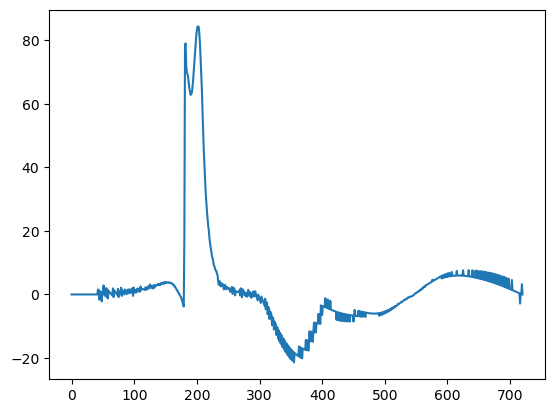

In [10]:
## отобразить на графике dQcdFi по углу поворота КВ
plt.plot(dQcdFi)

Скорость тепловыделения:
$$ \dfrac{dQ_{сг}} {d\phi} = Hu\dfrac{dx} {d\phi}q_c $$

График тепла   $ \dfrac{dx} {d\phi} $ от угла поворота КВ

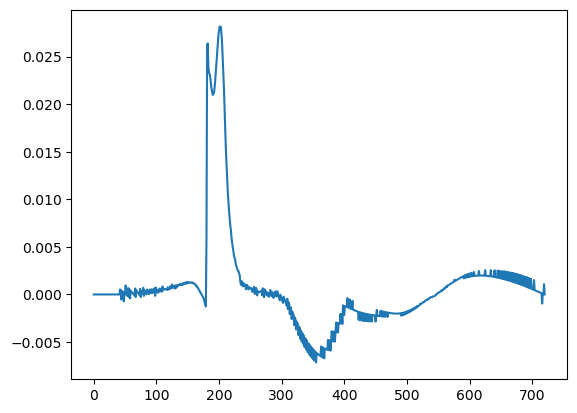

In [11]:
## отобразить на графике dXdFi (как dQcdFi/Hu/qc ) по углу поворота КВ
dXdFi = np.zeros((k+1,1))
for Fi in range (Fi_zvk, 720):
    dXdFi[Fi] = dQcdFi[Fi]/Hu/qc
plt.plot(dXdFi)

Необходимо на интервале где происходит сгорание - записать dXdFi в отдельную переменную

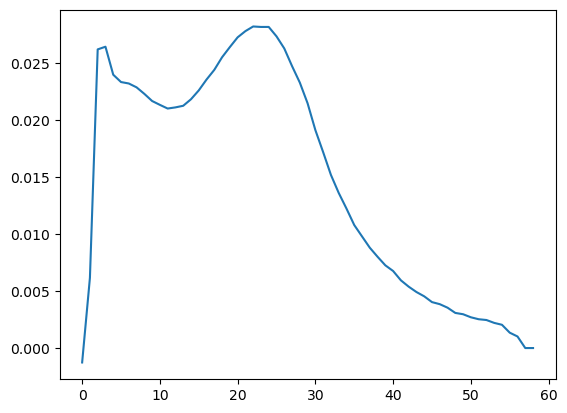

In [12]:
## отдельно записать в переменную участок dXdFi по углу поворота КВ от начала сгорания
a = 58
dXdFi_cr = np.zeros((k+1,1))
dXdFi_c = np.zeros((a+1,1))
for Fi in range (179, 236):
    dXdFi_cr[Fi-179] = dXdFi[Fi]

for Fi in range (0, 58):
    dXdFi_c[Fi] = dXdFi_cr[Fi]
plt.plot(dXdFi_c)

In [13]:
dXdFi_c

array([[-0.00126413],
       [ 0.00614876],
       [ 0.02616471],
       [ 0.02639866],
       [ 0.02394636],
       [ 0.02330366],
       [ 0.02317763],
       [ 0.02284012],
       [ 0.02226948],
       [ 0.021643  ],
       [ 0.02130528],
       [ 0.02098304],
       [ 0.02108346],
       [ 0.02122484],
       [ 0.02179679],
       [ 0.02257119],
       [ 0.02352258],
       [ 0.02437257],
       [ 0.02547681],
       [ 0.02636783],
       [ 0.0272209 ],
       [ 0.02776496],
       [ 0.02817207],
       [ 0.02813071],
       [ 0.02813187],
       [ 0.0273081 ],
       [ 0.02624767],
       [ 0.0247008 ],
       [ 0.02325506],
       [ 0.0214408 ],
       [ 0.01909498],
       [ 0.01716373],
       [ 0.01516846],
       [ 0.01359321],
       [ 0.01222052],
       [ 0.01077647],
       [ 0.00978098],
       [ 0.00878984],
       [ 0.00799606],
       [ 0.00724715],
       [ 0.0067497 ],
       [ 0.00593323],
       [ 0.00537889],
       [ 0.00490857],
       [ 0.00453146],
       [ 0

In [14]:
## отобразить на графике dXdFi  по углу поворота КВ

### Использование формулы Вибе для моделирования сгорания

Для дизельного двигателя можно записать с следующим виде:
$$ \dfrac{dx_{диз}} {d\phi} =  \dfrac{dx_{об}} {d\phi} + \dfrac{dx_{диф}} {d\phi} $$
Для объемного сгорания:
$$ \dfrac{dx_{об}} {d\phi} =\chi_t [\frac{m_t}{\phi_{сг}}][\frac{\phi}{\phi_{сг}}]exp(-\frac{m_t}{m_t+1}[\frac{\phi}{\phi_{сг}}]^{m_t+1})$$
Для диффузионного сгорания:
$$ \dfrac{dx_{диф}} {d\phi} = (1-\chi_t) C [\frac{m_v+1}{\phi_{z}}][\frac{\phi}{\phi_{z}}]exp(-C[\frac{\phi}{\phi_{z}}]^{m_v+1})$$
$ \chi_t $ - доля топлива сгоревшего по кинетическому механизму;

$ m_t $ - показатель кинетического сгорания;

$ \phi_{сг} $ - угол максимального скорости кинетического сгорания;

$ m_v $ - показатель объемного сгорания;

$ С = -ln[1-\Delta x] $ 

$\Delta x $ - доля сгоревшего топлива за весь процесс (обычно принимается ~0.99);

$ \phi_{z} $ - полная продолжительность процесса сгорания.

Необходимо подобрать константы (кроме тех, что можно "взять с графика")

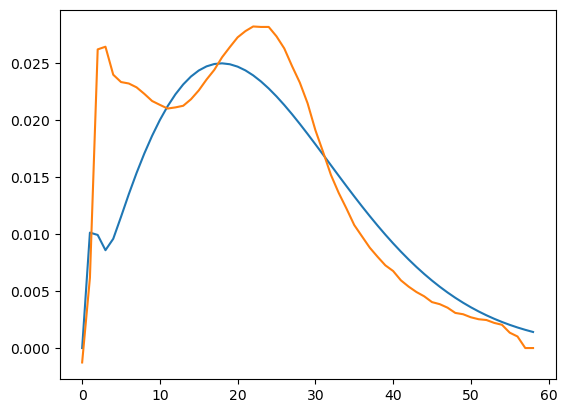

In [15]:
## записать выражения для констант в Формуле Вибе
ksi = 0.015
dx = 0.99
mt = 0.8
mv = 0.8
Fi_z = 58
Fi_c = 1
C = -np.log(1-dx)
dx_o = np.zeros((a+1,1))
dx_d = np.zeros((a+1,1))
dx_diz = np.zeros((a+1,1))
for Fi in range (0, 59):
    dx_o[Fi] = ksi * (mt/Fi_c)*(Fi/Fi_c)*np.exp(-mt/(mt+1)*(Fi/Fi_c)**(mt+1))
    dx_d[Fi] = (1-ksi)*C*((mv+1)/Fi_z)*(Fi/Fi_z) * np.exp(-C*(Fi/Fi_z)**(mt+1))
    dx_diz[Fi] = dx_o[Fi] + dx_d[Fi]
plt.plot(dx_diz)
plt.plot(dXdFi_c)

In [16]:
def funcdxdf(Fi,ksi,mt,mv,Fi_z,Fi_c):
    dx_o = ksi * (mt/Fi_c)*(Fi/Fi_c)*np.exp(-mt/(mt+1)*(Fi/Fi_c)**(mt+1))
    dx_d = (1-ksi)*C*((mv+1)/Fi_z)*(Fi/Fi_z) * np.exp(-C*(Fi/Fi_z)**(mt+1))
    dx_diz = dx_o + dx_d
    return dx_diz

In [17]:
def error(x):
    ksi1,mt1,mv1,Fi_c1 = x
    Fi = np.linspace(0,Fi_z, 59)
#    return sum((dXdFi_c[[num for num in range(len(dXdFi_c))]]-funcdxdf(Fi,ksi1,mt1,mv1,Fi_z,Fi_c))**4)
    dX = []
    x_func = funcdxdf(Fi,ksi1,mt1,mv1,Fi_z,Fi_c)
    for i in range (len(dXdFi_c)):
        dX.append((dXdFi_c[i]-x_func[i])**4)
    return sum(dX)

In [18]:
error([ksi,mt,mv,Fi_c])

array([2.50364933e-07])

In [19]:
rez = minimize(error,[ksi,mt,mv,Fi_c],method = 'BFGS',tol = 1e-6)
rez

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.9020075634588258e-07
        x: [ 3.159e-02  7.997e-01  8.007e-01  1.000e+00]
      nit: 3
      jac: [ 9.146e-07  3.442e-07 -2.722e-07  0.000e+00]
 hess_inv: [[ 2.191e+03 -4.429e+01  9.409e+01  0.000e+00]
            [-4.429e+01  1.896e+00 -1.903e+00  0.000e+00]
            [ 9.409e+01 -1.903e+00  5.042e+00  0.000e+00]
            [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
     nfev: 40
     njev: 8

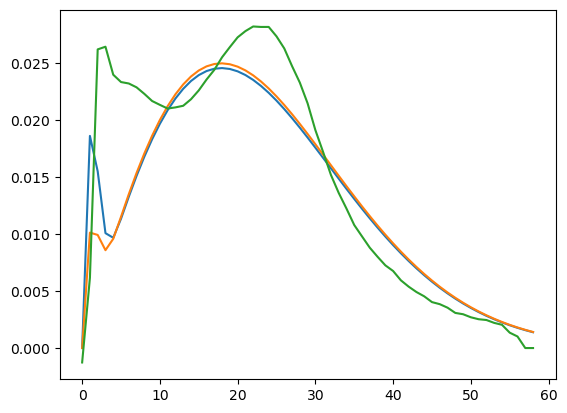

In [20]:
ksi1 = 3.159e-02
dx = 0.99
mt1 = 7.997e-1
mv1 = 8.007e-1
Fi_z = 58
Fi_c1 = 1
C = -np.log(1-dx)
dx_o1 = np.zeros((a+1,1))
dx_d1 = np.zeros((a+1,1))
dx_diz1 = np.zeros((a+1,1))
for Fi in range (0, 59):
    dx_o1[Fi] = ksi1 * (mt/Fi_c1)*(Fi/Fi_c1)*np.exp(-mt1/(mt1+1)*(Fi/Fi_c1)**(mt1+1))
    dx_d1[Fi] = (1-ksi1)*C*((mv1+1)/Fi_z)*(Fi/Fi_z) * np.exp(-C*(Fi/Fi_z)**(mt1+1))
    dx_diz1[Fi] = dx_o1[Fi] + dx_d1[Fi]
plt.plot(dx_diz1)
plt.plot(dx_diz)
plt.plot(dXdFi_c)

Записать функцию для определения скорости тепловыделения

In [21]:
## def функция по углу поворота - и ее скинуть в основной файл - попозже !

In [22]:
#Fi = np.linspace(0, 180, 180)
## создать переменную и используя функция записать значения скорости тепловыделения по углу поворота КВ

In [23]:
## Отобразить и сравнить получившиемся значения скорости тепловыделения